## This is a juptyer notebook detailing the various methods I used to train a W2v model on the Dow chemical dataset. Results summarized at the end

In [1518]:
# Library Imports

import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()
from gensim.models.doc2vec import TaggedDocument



from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [1519]:
# Loading the data into a pandas dataframe

main_data = pd.read_csv('/Users/andrewsimon/Desktop/Dow_dat.csv')
main_data

,Level,Report
0,2,"On April 10th at 12:30 PM, there was an incide..."
1,3,"On April 8th at 9:00 PM, a fire broke out in t..."
2,4,"On April 6th at 2:45 AM, there was an incident..."
3,1,"On April 5th at 7:15 PM, there was an unplanne..."
4,5,"On April 2nd at 11:30 AM, there was a minor in..."
...,...,...
295,3,"At 9:45 AM, a worker reported a small leak of ..."
296,5,"At 2:30 PM, a worker reported a small spill of..."
297,4,"At 6:15 AM, a worker reported an unusual odor ..."
298,2,"At 11:00 AM, a worker reported a small fire in..."


In [1520]:
# Exploring the distribution of values in safety levels:
print("Number of rows per safety level rating:")
print(main_data['Level'].value_counts())

Number of rows per safety level rating:
3    66
2    62
4    62
5    62
1    48
Name: Level, dtype: int64


### Tokenizing the data with the NTLK tokenizer and fitting the data to a Keras Sequential model. 

In [1521]:
# Tokenizer helper function
def tokenize(report):
    try:
        tokens = tokenizer.tokenize(report)
        return tokens
    except:
        return "NC"

In [1522]:
# Tokenizer wrapping function
def postprocess(data):
    data['tokens'] = data['Report'].progress_map(tokenize)
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

In [1523]:
# Tokenize the data with wrapping functions
data = main_data.copy()
data = postprocess(data)

progress-bar: 100%|██████████| 300/300 [00:00<00:00, 6221.99it/s]


In [1524]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(np.array(data.tokens),
                                                    np.array(data.Level), test_size=0.2, random_state=42)

In [1525]:
# Attach Doc2vec labels to each of our tokens
def labelizeReports(reports, label_type):
    labelized = []
    for i,v in tqdm(enumerate(reports)):
        label = '%s_%s'%(label_type,i)
        labelized.append(TaggedDocument(v, [label]))
    return labelized

X_train = labelizeReports(X_train, 'TRAIN')
X_test = labelizeReports(X_test, 'TEST')


240it [00:00, 1371434.55it/s]
60it [00:00, 121927.44it/s]


In [1526]:
# Fit train model
tweet_w2v = Word2Vec(vector_size=300, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(X_train)])
tweet_w2v.train([x.words for x in tqdm(X_train)], total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.epochs)

100%|██████████| 240/240 [00:00<00:00, 3471148.14it/s]


(39106, 90025)

In [1527]:
# Extract word embeddings
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))


/Users/andrewsimon/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1528]:
# Build word vectors from embeddings
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += google_vectors[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [1529]:
# Data postprocessing with sklearn, creating unit standard deviation
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in tqdm(map(lambda x: x.words, X_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in tqdm(map(lambda x: x.words, X_test))])
test_vecs_w2v = scale(test_vecs_w2v)

240it [00:00, 5753.63it/s]
60it [00:00, 5597.51it/s]


In [1530]:
# Training model
model = keras.Sequential()
model.add(keras.layers.Dense(32, activation='relu', input_dim=300))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(train_vecs_w2v, y_train, epochs=9, batch_size=32, verbose=2, validation_data = (test_vecs_w2v, y_test))

Epoch 1/9
8/8 - 0s - loss: 0.8034 - accuracy: 0.0042 - val_loss: -2.5347e+00 - val_accuracy: 0.0000e+00 - 315ms/epoch - 39ms/step
Epoch 2/9
8/8 - 0s - loss: -2.9687e+00 - accuracy: 0.0083 - val_loss: -5.3913e+00 - val_accuracy: 0.0000e+00 - 26ms/epoch - 3ms/step
Epoch 3/9
8/8 - 0s - loss: -5.5191e+00 - accuracy: 0.0125 - val_loss: -8.0628e+00 - val_accuracy: 0.0167 - 39ms/epoch - 5ms/step
Epoch 4/9
8/8 - 0s - loss: -7.9084e+00 - accuracy: 0.0125 - val_loss: -1.0688e+01 - val_accuracy: 0.0333 - 45ms/epoch - 6ms/step
Epoch 5/9
8/8 - 0s - loss: -1.0437e+01 - accuracy: 0.0208 - val_loss: -1.3523e+01 - val_accuracy: 0.0333 - 24ms/epoch - 3ms/step
Epoch 6/9
8/8 - 0s - loss: -1.3086e+01 - accuracy: 0.0250 - val_loss: -1.6275e+01 - val_accuracy: 0.0333 - 19ms/epoch - 2ms/step
Epoch 7/9
8/8 - 0s - loss: -1.5735e+01 - accuracy: 0.0333 - val_loss: -1.9181e+01 - val_accuracy: 0.0333 - 19ms/epoch - 2ms/step
Epoch 8/9
8/8 - 0s - loss: -1.8526e+01 - accuracy: 0.0458 - val_loss: -2.2269e+01 - val_accu

The model is performing worse than a random guess at this point. The tokenization leaves a large amount of stop words in the corpus, which can be solved using Gensim.preprocess.

### Using Gensim tokenization and preprocessing

In [1531]:
data_gensim = main_data.copy()

data_gensim['tokens'] = data_gensim['Report'].apply(lambda x: gensim.utils.simple_preprocess(x))
data_gensim.head()

,Level,Report,tokens
0,2,"On April 10th at 12:30 PM, there was an incide...","[on, april, th, at, pm, there, was, an, incide..."
1,3,"On April 8th at 9:00 PM, a fire broke out in t...","[on, april, th, at, pm, fire, broke, out, in, ..."
2,4,"On April 6th at 2:45 AM, there was an incident...","[on, april, th, at, am, there, was, an, incide..."
3,1,"On April 5th at 7:15 PM, there was an unplanne...","[on, april, th, at, pm, there, was, an, unplan..."
4,5,"On April 2nd at 11:30 AM, there was a minor in...","[on, april, nd, at, am, there, was, minor, inc..."


In [1532]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(np.array(data_gensim.tokens),
                                                    np.array(data_gensim.Level), test_size=0.2, random_state=42)

In [1533]:
X_train = labelizeReports(X_train, 'TRAIN')
X_test = labelizeReports(X_test, 'TEST')

# Fit train model
tweet_w2v = Word2Vec(vector_size=200, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(X_train)])
tweet_w2v.train([x.words for x in tqdm(X_train)], total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.epochs)

# Extract word embeddings
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))


# Data postprocessing with sklearn, creating unit standard deviation
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in tqdm(map(lambda x: x.words, X_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in tqdm(map(lambda x: x.words, X_test))])
test_vecs_w2v = scale(test_vecs_w2v)

# Training model
model_gensim = keras.Sequential()
model_gensim.add(keras.layers.Dense(32, activation='relu', input_dim=200))
model_gensim.add(keras.layers.Dense(1, activation='sigmoid'))
model_gensim.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_gensim.fit(train_vecs_w2v, y_train, epochs=9, batch_size=32, verbose=2, validation_data=(test_vecs_w2v, y_test))

240it [00:00, 354573.08it/s]
60it [00:00, 1052963.35it/s]
100%|██████████| 240/240 [00:00<00:00, 3756093.13it/s]
/Users/andrewsimon/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
0it [00:00, ?it/s]

ValueError: cannot reshape array of size 300 into shape (1,200)

Gensim preprocessing boosted our score to 0.17, slightly better but still worse performance than a random guess

### Using Padded Sequence Embeddings as labels

To remove the ragged arrays, Keras sequence padding can be used rather than taking a weighted average

In [ ]:
# Since tokenization did better for our model, use that for preprocessing
data_padded = main_data.copy()
data_padded = postprocess(data_padded)

progress-bar: 100%|██████████| 300/300 [00:00<00:00, 6266.86it/s]


In [ ]:
# Embedding vectors to an array from trained model, if out of vocabulary (oov) error occurs just add empty numpy array of all zeros

for i in range(len(data_padded['tokens'])):
    sub_list = []
    for j in data_padded['tokens'][i]:
        try:
            sub_list.append(tweet_w2v.wv.get_vector(j))
        except KeyError:
            sub_list.append(np.zeros(200,))
    data_padded['tokens'][i] = sub_list


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_padded['tokens'], data_padded['Level'], test_size=0.2, random_state=42)

In [ ]:
training_padded = pad_sequences(X_train, maxlen=120, truncating='post')
testing_padded = pad_sequences(X_test, maxlen=120, truncating='post')

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
# Create model, evaluate

batch = 32

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
num_epochs = 10
model.fit(training_padded, y_train, epochs=num_epochs,batch_size=batch, validation_data=(testing_padded, y_test))

Epoch 1/10
8/8 [==============================] - 0s 12ms/step - loss: 0.6851 - accuracy: 0.1417 - val_loss: 0.6710 - val_accuracy: 0.1333
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6650 - accuracy: 0.1667 - val_loss: 0.6487 - val_accuracy: 0.1333
Epoch 3/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6449 - accuracy: 0.1667 - val_loss: 0.6264 - val_accuracy: 0.1333
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.1667 - val_loss: 0.6041 - val_accuracy: 0.1333
Epoch 5/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6049 - accuracy: 0.1667 - val_loss: 0.5816 - val_accuracy: 0.1333
Epoch 6/10
8/8 [==============================] - 0s 4ms/step - loss: 0.5845 - accuracy: 0.1667 - val_loss: 0.5595 - val_accuracy: 0.1333
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: 0.5647 - accuracy: 0.1667 - val_loss: 0.5375 - val_accuracy: 0.1333
Epoch 8/10
8/8 [=================

### Using pre-trained word corpus on data

Rather than building our own model, use embeddings generated from a pretrained corpus on Gensim

In [ ]:
# Since tokenization did better for our model, use that for preprocessing
data_pre_trained = main_data.copy()
data_pre_trained['tokens'] = data_pre_trained['Report'].apply(lambda x: gensim.utils.simple_preprocess(x))

In [1547]:
 google_vectors = gensim.downloader.load('word2vec-google-news-300')

In [1548]:
# Embedding vectors to an array from trained model, if out of vocabulary (oov) error occurs just add empty numpy array of all zeros

for i in range(len(data_pre_trained['tokens'])):
    sub_list = []
    for j in data_pre_trained['tokens'][i]:
        try:
            sub_list.append(google_vectors[j])
        except KeyError:
            sub_list.append(np.zeros(200,))
    data_pre_trained['tokens'][i] = sub_list


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_pre_trained['tokens'], data_pre_trained['Level'], test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

training_padded = pad_sequences(X_train, maxlen=60, truncating='post')
testing_padded = pad_sequences(X_test, maxlen=60, truncating='post')

In [ ]:
# Create model, evaluate

batch = 32

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
num_epochs = 10
model.fit(training_padded, y_train, epochs=num_epochs,batch_size=batch, validation_data=(testing_padded, y_test))

Epoch 1/10
8/8 [==============================] - 0s 12ms/step - loss: -1.4055 - accuracy: 0.1667 - val_loss: -4.0929 - val_accuracy: 0.1333
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: -5.2354 - accuracy: 0.1667 - val_loss: -8.4463 - val_accuracy: 0.1333
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: -9.1619 - accuracy: 0.1667 - val_loss: -12.9220 - val_accuracy: 0.1333
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: -13.1349 - accuracy: 0.1667 - val_loss: -17.5737 - val_accuracy: 0.1333
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: -17.3283 - accuracy: 0.1667 - val_loss: -22.3251 - val_accuracy: 0.1333
Epoch 6/10
8/8 [==============================] - 0s 4ms/step - loss: -21.6444 - accuracy: 0.1667 - val_loss: -27.3446 - val_accuracy: 0.1333
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: -26.2398 - accuracy: 0.1667 - val_loss: -32.5498 - val_accuracy: 0.1333
Epoch 8/10

### Vectorization with SKLearn

In [1549]:
# Since tokenization did better for our model, use that for preprocessing
data_SkLearn= main_data.copy()
data_SKLearn = postprocess(data_SkLearn)


progress-bar: 100%|██████████| 300/300 [00:00<00:00, 5242.46it/s]


In [1550]:
X_train, X_test, y_train, y_test = train_test_split(data_SkLearn['tokens'], data_SkLearn['Level'], test_size=0.2, random_state=42)

In [1551]:
X_train = labelizeReports(X_train, 'TRAIN')
X_test = labelizeReports(X_test, 'TEST')

# Fit train model
tweet_w2v = Word2Vec(vector_size=200, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(X_train)])
tweet_w2v.train([x.words for x in tqdm(X_train)], total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.epochs)

# Extract word embeddings
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))


# Data postprocessing with sklearn, creating unit standard deviation
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in tqdm(map(lambda x: x.words, X_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in tqdm(map(lambda x: x.words, X_test))])
test_vecs_w2v = scale(test_vecs_w2v)


240it [00:00, 444625.87it/s]

60it [00:00, 600616.32it/s]

100%|██████████| 240/240 [00:00<00:00, 1921055.27it/s]

100%|██████████| 240/240 [00:00<00:00, 1981560.94it/s]
/Users/andrewsimon/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)

240it [00:00, 5914.27it/s]

60it [00:00, 5805.93it/s]


In [ ]:
clf_decision_tree = DecisionTreeClassifier()

clf_decision_tree.fit(train_vecs_w2v, y_train)

predictions = clf_decision_tree.predict(test_vecs_w2v)

acc_score = accuracy_score(y_test, predictions)

acc_score

0.45

In [1554]:
classifier = LogisticRegression( max_iter = 100000)
classifier.fit(train_vecs_w2v, y_train)
predictions_LR = classifier.predict(test_vecs_w2v)
score = classifier.score(predictions_LR, y_test)
score


ValueError: Expected 2D array, got 1D array instead:
array=[1 4 5 5 2 4 4 3 3 3 4 3 3 4 5 3 1 3 3 5 5 5 1 4 4 4 3 3 2 2 5 2 2 2 2 1 4
 2 3 5 4 2 5 3 2 5 5 4 2 2 1 1 5 2 2 5 5 2 4 3].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=800, random_state=11).fit(train_vecs_w2v, y_train)

predictions = rf.predict(train_vecs_w2v)

score = rf.score(test_vecs_w2v, y_test)

score


0.5166666666666667

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(max_depth = 6, n_estimators = 1000).fit(train_vecs_w2v, y_train)

predictions = xgb.predict(test_vecs_w2v)

score = xgb.score(test_vecs_w2v, y_test)

score

0.48333333333333334

AttributeError: 'ConfusionMatrixDisplay' object has no attribute 'show'

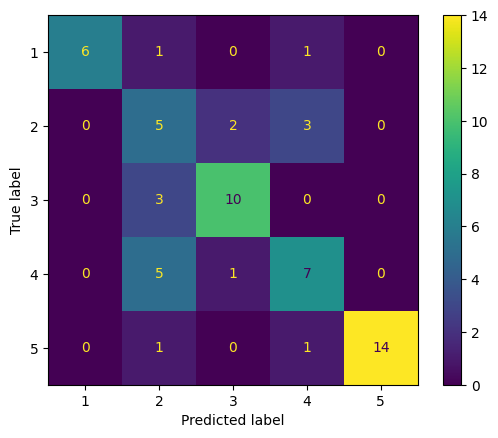

In [1553]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

len(y_test)
cm = confusion_matrix(y_test, predictions_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [1,2,3,4,5])
disp.plot()
disp.show()
